* MNIST inverse network
* Newsgroups inverse network
* Squared error loss and classification loss
  * Also with L1 regularisation

In [96]:
import sys
import cPickle as pickle
import gzip
import random
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../modules/")
import helper as hp
# ----
import theano
from theano import tensor as T
import lasagne
import numpy as np
# ---
from skimage import io
# ---
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.init import *
from lasagne.updates import *
from lasagne.regularization import *
# ---
from scipy.io import loadmat
# ---
random.seed(0)
np.random.seed(0)

In [574]:
%load_ext rmagic

//anaconda/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


In [62]:
def print_net(out):
    for layer in get_all_layers(out):
        print layer.output_shape
    print count_params(out)

* Load in the newsgroup dataset
* Add 100 random $U(0,1)$ (discrete) attributes to the end.

In [159]:
data = loadmat("../data/20news_w100.mat")
X_total = data["documents"].toarray().T
X_total = np.asarray(X_total, dtype="float32")
X_noise = np.asarray(np.random.randint(0, 2, (X_total.shape[0], X_total.shape[1])), dtype="float32")
X_total = np.hstack( (X_total, X_noise) )
y_total = data["newsgroups"]-1
y_total = np.asarray(y_total[0],dtype="int32")

In [160]:
def simple_mlp(X_data, y_data, lamb=0.0):
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_out = DenseLayer(a_in, num_units=np.max(y_data)+1, nonlinearity=softmax)   
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn}

In [161]:
mlp1 = simple_mlp(X_total, y_total, lamb=1e-4)

In [162]:
print_net(mlp1["net"])

(None, 200)
(None, 4)
804


In [163]:
def train_net(X_train, y_train, train_fn, num_epochs, batch_size, shuffle=True):
    idxs = [x for x in range(0, X_train.shape[0])]
    Xt, yt = X_train, y_train
    for epoch in range(0, num_epochs):
        if shuffle:
            random.shuffle(idxs)
            Xt = X_train[idxs]
            yt = y_train[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        print np.mean(losses)

In [143]:
def get_accuracy(X_train, y_train, predict_fn):
    return float(np.sum(np.argmax(predict_fn(X_train),axis=1) == y_train)) / len(y_train)

In [154]:
def get_mean_abs_grad(X_train, y_train, x_grad_fn):
    return np.mean(np.abs(x_grad_fn(X_train, y_train)),axis=0)

* Train a simple perceptron MLP on the newsgroup dataset with $L_{1}$
* Look at the accuracy and a plot of the mean absolute gradients over the training set (we expect the noise attributes to have low gradients)

In [164]:
train_net(X_total, y_total, mlp1["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.23782492573
0.960639491297
0.848167788826
0.784305225545
0.743613367122
0.713672729464
0.691508968917
0.674317077775
0.660457236334
0.647527825989
0.63826223627
0.629079979089
0.621915280712
0.615667768524
0.60946658993
0.604178421548
0.599059228146
0.595081339638
0.591303508491
0.587313707409
0.584546975842
0.581150863592
0.578920502777
0.576257051497
0.573726568034
0.570987052064
0.569266816217
0.567626849824
0.565838529677
0.563938650743
0.562113950668
0.56032212932
0.559437404324
0.55771197196
0.557043260298
0.555486703026
0.554498902576
0.552672347261
0.552092306087
0.55127030752
0.550372989862
0.549320239056
0.548901000415
0.547335477268
0.546944026156
0.545982552765
0.545147662821
0.544118613568
0.543581190859
0.543280369104
0.542228214874
0.541875568586
0.541428510473
0.540986840894
0.54008416404
0.539583482373
0.539327911776
0.539311553776
0.538282317624
0.537281528075
0.537239494005
0.536886463901
0.536271668828
0.536607975535
0.535751097298
0.535342858907
0.534710173516
0.

In [165]:
get_accuracy(X_total, y_total, mlp1["predict_fn"])

0.8180642777983007

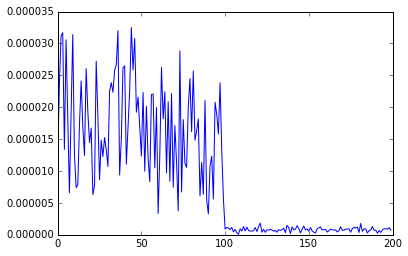

In [166]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp1["x_grad_fn"]) )

* Do the same thing but train an MLP (one hidden layer, with 100 hidden units)
* Evaluate accuracy
* Evaluate gradient plots for the input layer and the hidden layer

In [569]:
def mlp(X_data, y_data, num_hidden_units=None, lamb=0.0):
    if num_hidden_units == None:
        num_hidden_units = X_data.shape[1]/2
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_hidden = DenseLayer(a_in, num_units=num_hidden_units)
    a_out = DenseLayer(a_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax)
    # hacky
    z_hidden = InputLayer(a_hidden.output_shape, W=a_hidden.W)
    z_out = DenseLayer(z_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax, W=a_out.W)
    # ---
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    z_loss = categorical_crossentropy( get_output(z_out, X), y ).mean() + \
        lamb*regularize_layer_params(z_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    # the loss fn is defined in terms of X -> hidden -> out
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    # hacky
    hidden_grad_fn = theano.function([X, y], T.grad(z_loss, X))
    hidden_predict_fn = theano.function([X], get_output(a_hidden, X))
    # ---
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "hidden_grad_fn":hidden_grad_fn,
            "hidden_predict_fn":hidden_predict_fn,
            "loss_fn": loss_fn}

In [230]:
mlp2 = mlp(X_total, y_total, lamb=1e-4)

(None, 100)


In [232]:
train_net(X_total, y_total, mlp2["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.19901941848
0.80897760697
0.652031093172
0.593974877305
0.565017012846
0.551322376491
0.537515358757
0.529481812419
0.523333190462
0.517985284556
0.514454321247
0.508864846068
0.504042333193
0.501687158622
0.497792434021
0.493968811041
0.491689533601
0.486200291181
0.483582250672
0.481528231983
0.47762103487
0.472464986878
0.469549716484
0.466590889793
0.463653685988
0.456291002157
0.453850043824
0.450046695938
0.445938526074
0.441542643846
0.437549192395
0.433138419964
0.42956714582
0.424302895376
0.420501219242
0.415909556831
0.409319371419
0.4077957623
0.402048293658
0.397617418716
0.392250389816
0.387710230799
0.383632947576
0.378012766043
0.374251000022
0.369855143134
0.365644248687
0.361564081911
0.355574970892
0.352051685288
0.347322243599
0.343366729663
0.338423631994
0.333707069676
0.329851023632
0.325194626334
0.320559384676
0.317959594831
0.312393026207
0.307730210612
0.302853843776
0.300316258339
0.295066695261
0.291609548663
0.287978236912
0.285015198948
0.281155894635
0

In [219]:
get_accuracy(X_total, y_total, mlp2["predict_fn"])

0.9999384312276813

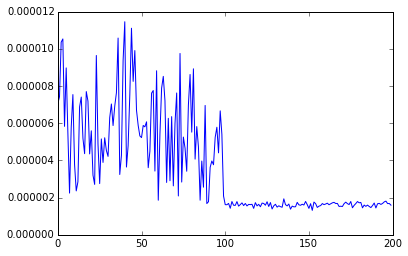

In [220]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp2["x_grad_fn"]) )

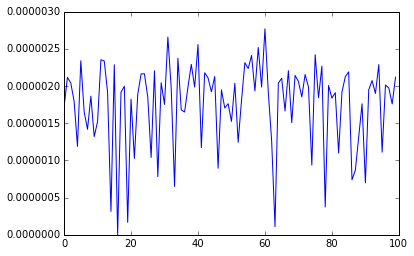

In [246]:
plt.plot( np.mean(np.abs(mlp2_hidden_grads), axis=0) )

* Generate an MLP with no $L_{1}$ regularisation (we want to overfit the training set, and see how the validation set reacts).
* Let's train our network and after each epoch, save a plot of the (validation set) input and hidden gradients to disk.

In [277]:
%%bash
mkdir -p feature_ranking_out/input_grads
mkdir -p feature_ranking_out/hidden_grads

In [378]:
mlp3 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)

(None, 100)


In [342]:
print_net(mlp3["net"])

(None, 200)
(None, 100)
(None, 4)
20504


Cut the data into training and validation.

In [283]:
X_total.shape, y_total.shape

((16242, 200), (16242,))

In [293]:
idxs = [x for x in range(0, X_train.shape[0])]
random.shuffle(idxs)
train_idxs = idxs[0 : int(0.75*len(idxs))]
valid_idxs = idxs[int(0.75*len(idxs)) :: ]
Xt, yt, Xv, yv = X_total[train_idxs], y_total[train_idxs], X_total[valid_idxs], y_total[valid_idxs]

In [294]:
Xt.shape, yt.shape, Xv.shape, yv.shape

((12181, 200), (12181,), (4061, 200), (4061,))

In [377]:
def graph_grad_train(Xt, yt, Xv, yv, mlp, num_epochs=20):
    
    hidden_grads_arr = []
    input_grads_arr = []
    
    idxs = [x for x in range(0, Xt.shape[0])]
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = mlp["train_fn"](
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        input_grads = mlp["x_grad_fn"](Xv, yv)
        input_grads = np.mean(np.abs(input_grads), axis=0)
        hidden_grads = mlp["hidden_grad_fn"]( mlp["hidden_predict_fn"](Xv).astype("float32"), yv)
        hidden_grads = np.mean(np.abs(hidden_grads), axis=0)       
        
        # save grads
        input_grads_arr.append(input_grads)
        hidden_grads_arr.append(hidden_grads)
        this_valid_loss = mlp["loss_fn"](Xv, yv)
        print "train loss, valid loss = %f, %f" % (np.mean(losses), this_valid_loss)
       
    print "plotting..."
    biggest_input_max = -1
    biggest_hidden_max = -1
    for i in range(0, len(hidden_grads_arr)):
        if np.max(hidden_grads_arr[i]) > biggest_hidden_max:
            biggest_hidden_max = np.max(hidden_grads_arr[i])
        if np.max(input_grads_arr[i]) > biggest_input_max:
            biggest_input_max = np.max(input_grads_arr[i])
            
    for epoch in range(0, num_epochs):
        plt.ylim(0, biggest_hidden_max)
        plt.plot(hidden_grads_arr[epoch])
        plt.savefig("feature_ranking_out/hidden_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()
        plt.ylim(0, biggest_input_max)
        plt.plot(input_grads_arr[epoch])
        plt.savefig("feature_ranking_out/input_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()

In [379]:
graph_grad_train(Xt, yt, Xv, yv, mlp3, num_epochs=100)

train loss, valid loss = 1.255504, 1.085376
train loss, valid loss = 0.933350, 0.838087
train loss, valid loss = 0.741755, 0.701784
train loss, valid loss = 0.647006, 0.646907
train loss, valid loss = 0.597360, 0.604032
train loss, valid loss = 0.567649, 0.633877
train loss, valid loss = 0.548819, 0.575458
train loss, valid loss = 0.536249, 0.566892
train loss, valid loss = 0.525504, 0.597286
train loss, valid loss = 0.521782, 0.595822
train loss, valid loss = 0.515406, 0.547165
train loss, valid loss = 0.505562, 0.563671
train loss, valid loss = 0.499192, 0.582680
train loss, valid loss = 0.498338, 0.544197
train loss, valid loss = 0.490663, 0.544855
train loss, valid loss = 0.484023, 0.591073
train loss, valid loss = 0.484626, 0.543590
train loss, valid loss = 0.475822, 0.540308
train loss, valid loss = 0.473984, 0.548123
train loss, valid loss = 0.469962, 0.550181
train loss, valid loss = 0.467573, 0.564162
train loss, valid loss = 0.463952, 0.550215
train loss, valid loss = 0.45561

In [373]:
get_accuracy(Xt, yt, mlp3["predict_fn"]), get_accuracy(Xv, yv, mlp3["predict_fn"])

(0.989902306871357, 0.7549864565377986)

* Over time, the validation set gradients for input/hidden layers gets larger. Is this because the network is overfitting the training set, and hence the $\frac{dL}{dx}$ has hit a local minimum, whereas this is not the case with the validation set?
* Let's look at the hidden activation gradients for the validation set, and sort them

In [413]:
mlp3_hidden_grads = np.mean(np.abs(mlp3["hidden_grad_fn"]( mlp3["hidden_predict_fn"](Xv).astype("float32"), yv)), axis=0)

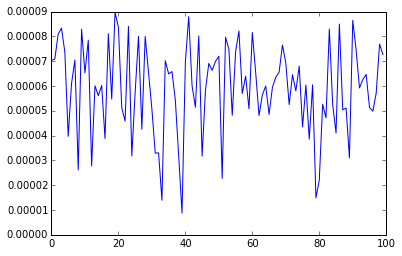

In [415]:
plt.plot(mlp3_hidden_grads)

In [435]:
np.argsort(mlp3_hidden_grads)

array([39, 33, 79, 80, 51,  8, 12, 89, 45, 24, 38, 31, 32, 77, 16,  5, 85,
       27, 75, 22, 82, 62, 54, 65, 96, 87, 30, 59, 88, 21, 95, 43, 84, 71,
       81, 37, 18, 14, 63, 57, 97, 25, 73, 46, 92, 66, 64, 13, 42, 15, 76,
       78,  6, 93, 67, 58, 72, 94, 35, 10, 29, 61, 68, 36, 48, 74, 47, 70,
       40, 49, 34,  0,  7,  1, 50, 99,  4, 55, 91, 53, 69, 98, 11, 52, 28,
       26, 44,  2, 17, 60, 56,  9, 83,  3, 20, 23, 86, 90, 41, 19])

* Can we visualise a histogram of hidden activation gradients (over the validation set) for each hidden unit?

(array([   63.,   113.,   171.,   210.,  1510.,  1562.,   178.,   135.,
           96.,    23.]),
 array([ -6.32923745e-05,  -5.06339856e-05,  -3.79755967e-05,
         -2.53172079e-05,  -1.26588190e-05,  -4.30141856e-10,
          1.26579587e-05,   2.53163476e-05,   3.79747365e-05,
          5.06331253e-05,   6.32915142e-05]),
 <a list of 10 Patch objects>)

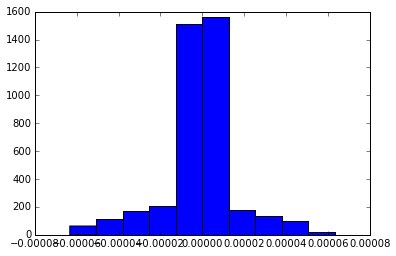

In [453]:
plt.hist( mlp3["hidden_grad_fn"]( mlp3["hidden_predict_fn"](Xv).astype("float32"), yv)[:,39] )

* Train on all minibatches
* Evaluate performance of hidden layer on validation set
* Find the M worst hidden units (i.e. the ones with high mean gradients), and reinitialise their weights

In [603]:
np.ones((10,10))[:,5]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [614]:
def adaptive_train(Xt, yt, Xv, yv, mlp, num_to_fix, check_every, num_epochs=20, add_noise=False, print_out=True):
    sampler = GlorotUniform()
    idxs = [x for x in range(0, Xt.shape[0])]
    train_fn = mlp["train_fn"]
    hidden_predict_fn = mlp["hidden_predict_fn"]
    hidden_grad_fn = mlp["hidden_grad_fn"]
    net = mlp["net"]
    h_grads_arr = []
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        h_grads = np.mean(np.abs(hidden_grad_fn( hidden_predict_fn(Xv).astype("float32"), yv)), axis=0)
        h_grads_arr.append(h_grads)
        h_idxs = np.argsort(h_grads)[::-1]
        #print "units to fix: %s" % str(h_idxs[0:num_to_fix])
        if num_to_fix > 0 and (epoch+1) % check_every == 0:
            W = net.input_layer.W.get_value()
            for idx in h_idxs[0:num_to_fix]:
                if add_noise:
                    W[:,idx] += np.random.normal(0, 0.1, size=( W[:,idx].shape[0], 1) ).flatten()
                else:
                    W[:,idx] = sampler.sample( ( W[:,idx].shape[0], 1) ).flatten()
            net.input_layer.W.set_value(W)
        if print_out:
            print np.mean(losses)
    return h_grads_arr

In [611]:
for check_every in [1, 20]:
    rows_to_write = []
    for num_to_fix in [0, 5, 10, 20, 40, 80]:
        valid_accs = []
        for x in range(0, 10):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp4 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train(
                Xt, yt, Xv, yv, mlp4, num_epochs=100, num_to_fix=num_to_fix, check_every=check_every, print_out=False)
            valid_acc = get_accuracy(Xv, yv, mlp4["predict_fn"])
            row.append(valid_acc)
            valid_accs.append(valid_acc)
            rows_to_write.append(row)
            print row
    with open("feature_ranking_out_adaptive/stats%i.csv" % check_every, "wb") as f:
        f.write("num_to_fix,seed,valid_accuracy\n")
        for row in rows_to_write:
            f.write(",".join( [str(r) for r in row] ) + "\n")

[0, 0, 0.7709923664122137]
[0, 1, 0.7589263728145776]
[0, 2, 0.756217680374292]
[0, 3, 0.7606500861856685]
[0, 4, 0.7576951489780842]
[0, 5, 0.7606500861856685]
[0, 6, 0.758680128047279]
[0, 7, 0.7690224082738242]
[0, 8, 0.7655749815316425]
[0, 9, 0.7576951489780842]
[5, 0, 0.6631371583353853]
[5, 1, 0.5289337601575966]
[5, 2, 0.5779364688500369]
[5, 3, 0.6042846589509973]
[5, 4, 0.7114011327259295]
[5, 5, 0.6766806205368135]
[5, 6, 0.6857916769268653]
[5, 7, 0.6680620536813593]
[5, 8, 0.5481408520068949]
[5, 9, 0.6572272839202167]
[10, 0, 0.45284412706229993]
[10, 1, 0.6338340310268407]
[10, 2, 0.4550603299679882]
[10, 3, 0.548879586308791]
[10, 4, 0.41738488057128786]
[10, 5, 0.5252400886481162]
[10, 6, 0.5422309775917262]
[10, 7, 0.607732085693179]
[10, 8, 0.5799064269884265]
[10, 9, 0.6646146269391775]
[20, 0, 0.45776902240827383]
[20, 1, 0.4444718049741443]
[20, 2, 0.5213001723713371]
[20, 3, 0.40384141836985965]
[20, 4, 0.6330952967249446]
[20, 5, 0.3504063038660428]
[20, 6, 0.37

* Weight change every epoch = 80 does better than everything else (seems too brute force?)
* Weight change every 20 epochs = 80 does worse

In [615]:
for check_every in [20]:
    rows_to_write = []
    for num_to_fix in [0, 5, 10]:
        valid_accs = []
        # row in the format "num_to_fix,seed,valid_acc
        for x in range(0, 10):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp4 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train(
                Xt, yt, Xv, yv, mlp4, num_epochs=100, num_to_fix=num_to_fix, check_every=check_every, add_noise=True, print_out=False)
            valid_acc = get_accuracy(Xv, yv, mlp4["predict_fn"])
            row.append(valid_acc)
            valid_accs.append(valid_acc)
            rows_to_write.append(row)
            print row

    with open("feature_ranking_out_adaptive/noise_stats%i.csv" % check_every, "wb") as f:
        f.write("num_to_fix,seed,valid_accuracy\n")
        for row in rows_to_write:
            f.write(",".join( [str(r) for r in row] ) + "\n")

[0, 0, 0.7709923664122137]
[0, 1, 0.7589263728145776]
[0, 2, 0.756217680374292]
[0, 3, 0.7606500861856685]
[0, 4, 0.7576951489780842]
[0, 5, 0.7606500861856685]
[0, 6, 0.758680128047279]
[0, 7, 0.7690224082738242]
[0, 8, 0.7655749815316425]
[0, 9, 0.7576951489780842]
[5, 0, 0.7522777640975129]
[5, 1, 0.7453829106131494]
[5, 2, 0.7453829106131494]
[5, 3, 0.7535089879340064]
[5, 4, 0.7544939670032011]
[5, 5, 0.7443979315439547]
[5, 6, 0.7552327013050972]
[5, 7, 0.7653287367643438]
[5, 8, 0.7463678896823442]
[5, 9, 0.7463678896823442]
[10, 0, 0.7557251908396947]
[10, 1, 0.7244521053927604]
[10, 2, 0.741689239103669]
[10, 3, 0.7468603792169416]
[10, 4, 0.7054912583107609]
[10, 5, 0.7512927850283182]
[10, 6, 0.7532627431667077]
[10, 7, 0.7493228268899286]
[10, 8, 0.7411967495690717]
[10, 9, 0.7495690716572273]


In [555]:
for i in range(0, len(h_grads_arr)):
    plt.ylim(0, 0.000050)
    plt.plot(h_grads_arr[i])
    plt.savefig("feature_ranking_out_adaptive/%s.png" % str(i+1).zfill(2))
    plt.close()

----

* Plot the gradients on MNIST digits. This makes a nice visualisation which could make it into the paper.

In [380]:
sys.path.append("../modules/")
import helper as hp

In [381]:
mnist_train_set, _, _ = hp.load_mnist()

In [387]:
mnist_x, mnist_y = mnist_train_set
mnist_x = mnist_x.astype("float32")
mnist_y = mnist_y.astype("int32")

In [383]:
def simple_conv(X_data, y_data):
    a_in = InputLayer( (None, 1, 28, 28 ) )
    a_conv1 = Conv2DLayer(a_in, num_filters=16, filter_size=(5,5), nonlinearity=rectify)
    a_mp1 = MaxPool2DLayer(a_conv1, pool_size=(2,2))
    a_conv2 = Conv2DLayer(a_mp1, num_filters=32, filter_size=(5,5), nonlinearity=rectify)
    a_mp2 = MaxPool2DLayer(a_conv2, pool_size=(2,2))
    a_out = DenseLayer(a_mp2, num_units=np.max(y_data)+1, nonlinearity=softmax)  
    X = T.tensor4('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean()
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn}

In [384]:
conv = simple_conv(mnist_x, mnist_y)

In [388]:
train_net(mnist_x, mnist_y, conv["train_fn"], num_epochs=5, batch_size=64)

0.26089267387
0.0771458087307
0.0571138216773


KeyboardInterrupt: 

In [393]:
mnist_x_9 = mnist_x[ (mnist_y == 9) ]
mnist_y_9 = np.asarray([9 for x in range(0, mnist_x_9.shape[0])], dtype="int32")

In [394]:
grads_for_9 = conv["x_grad_fn"](mnist_x_9, mnist_y_9)

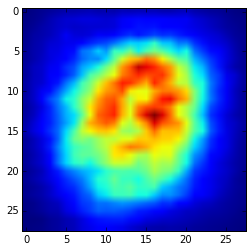

In [403]:
plt.imshow( np.mean(np.abs(grads_for_9),axis=0)[0] )

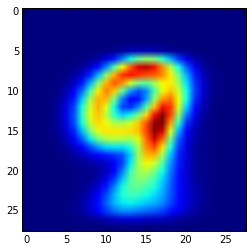

In [404]:
plt.imshow( np.mean(np.abs(mnist_x_9),axis=0)[0] )

----

* Not using autoencoders, because the noise attributes actually get larger gradients. Because they have no structure to them, the network allocates more capacity to them, and hence they end up being more important attributes.